In [ ]:
### contributed by Elakia and Rustam

In [ ]:
### Python Env Python 3.10.16

In [ ]:
!pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow pillow

In [2]:

import os
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.applications import VGG16, DenseNet201, Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam

In [3]:
# CLAHE enhancement
def enhance_image(image_array):
    lab = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced

In [4]:
# Load images
def load_images_and_labels(dataset_path, img_size=(224, 224)):
    categories = ['benign', 'malignant']
    data, labels = [], []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(img_size)
                enhanced = enhance_image(np.array(img))
                data.append(enhanced)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return np.array(data), np.array(labels)

In [5]:
# Load dataset
path = r"C:\Users\LLR User\Desktop\Coding\code\skin-cancer\Dataset"
X, y_labels = load_images_and_labels(path)
X = X.astype(np.float32)
le = LabelEncoder()
y = le.fit_transform(y_labels)

In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
mean = np.mean(X_train, axis=(0, 1, 2), keepdims=True)
std = np.std(X_train, axis=(0, 1, 2), keepdims=True)
std[std == 0] = 1e-6
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [7]:
# tf.data pipelines
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image, tf.one_hot(label, depth=2)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess, AUTOTUNE)
train_ds = train_ds.map(augment, AUTOTUNE).shuffle(1024).batch(32).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess, AUTOTUNE).batch(32).prefetch(AUTOTUNE)


In [8]:
# Custom CNN
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)), BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)), BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)), BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
# Transfer models
def build_transfer_model(base_model_fn, input_shape=(224, 224, 3)):
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# Plotting
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [12]:
# Train + Evaluate
architectures = {
    "CustomCNN": build_custom_cnn,
    "VGG16": lambda: build_transfer_model(VGG16),
    "DenseNet201": lambda: build_transfer_model(DenseNet201),
    "Xception": lambda: build_transfer_model(Xception)
}


🔧 Training model: CustomCNN


c:\Users\LLR User\miniconda3\envs\tf-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 977ms/step - accuracy: 0.7267 - loss: 1.7017 - val_accuracy: 0.5474 - val_loss: 2.6182
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7747 - loss: 0.8667 - val_accuracy: 0.5474 - val_loss: 2.5977
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8007 - loss: 0.6309 - val_accuracy: 0.5474 - val_loss: 2.2866
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8020 - loss: 0.6153 - val_accuracy: 0.5569 - val_loss: 2.1967
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8227 - loss: 0.5163 - val_accuracy: 0.5853 - val_loss: 2.0377
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step

✅ CustomCNN Accuracy: 0.5853
📋 Classification Report for CustomCNN:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       231
           1       1.00      0.08      0.15       191

    accuracy                           0.59       422
   macro avg       0.78      0.54      0.44 

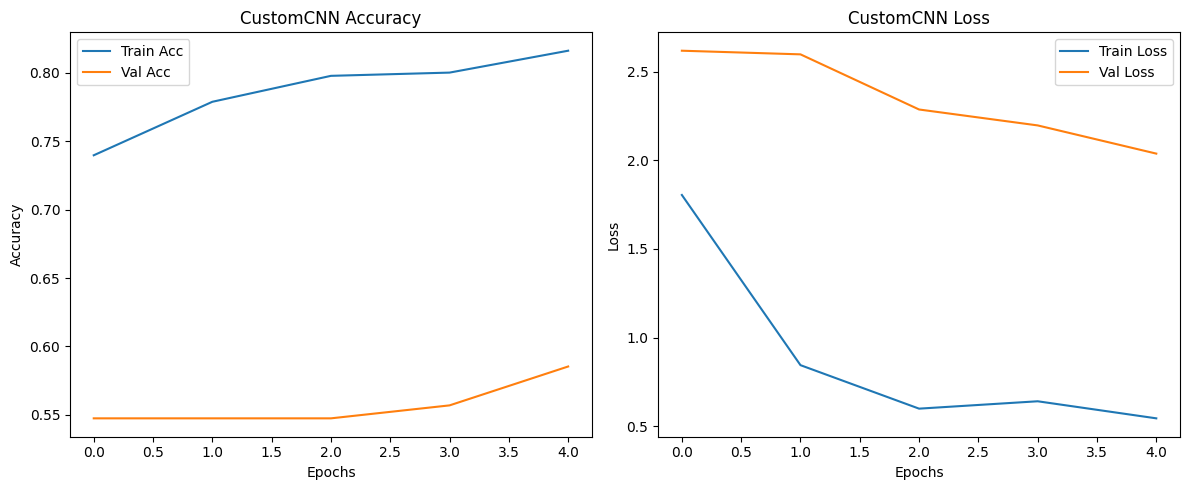

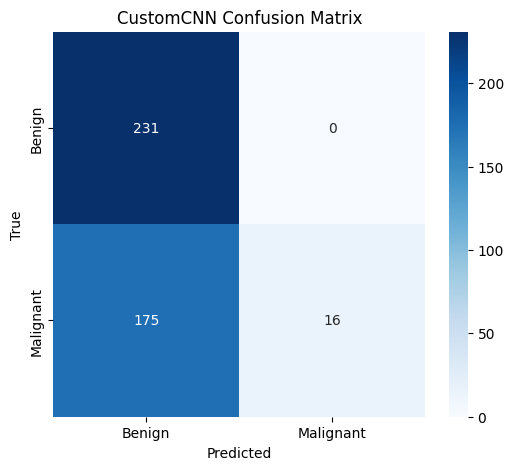


🔧 Training model: VGG16
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.5332 - loss: 0.8465 - val_accuracy: 0.5806 - val_loss: 0.6688
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - accuracy: 0.5510 - loss: 0.7626 - val_accuracy: 0.6872 - val_loss: 0.6075
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.6137 - loss: 0.6825 - val_accuracy: 0.7630 - val_loss: 0.5618
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.6319 - loss: 0.6438 - val_accuracy: 0.7654 - val_loss: 0.5309
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.6740 - loss: 0.6095 - val_accuracy: 0.7630 - val_loss: 0.5044
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step

✅ VGG16 Accuracy: 0.7630
📋 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       231
           1       0.75      0.72      0.73       191

    accuracy                           0.76       422
   macro avg       0.76    

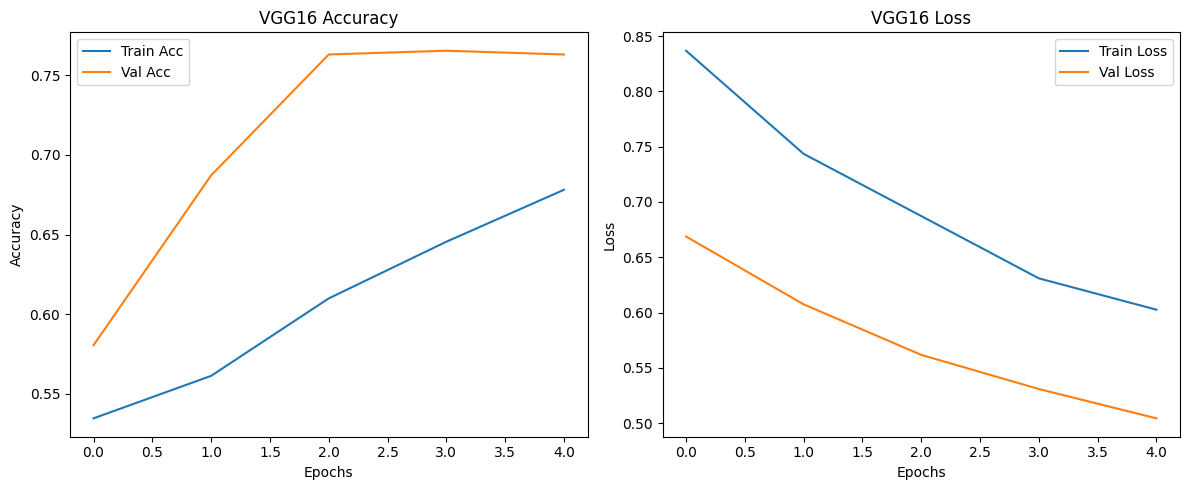

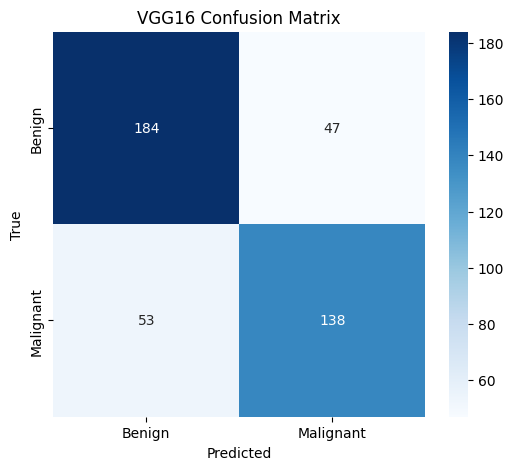


🔧 Training model: DenseNet201
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.6029 - loss: 0.8018 - val_accuracy: 0.7749 - val_loss: 0.4734
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.7340 - loss: 0.5596 - val_accuracy: 0.7701 - val_loss: 0.4418
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.7802 - loss: 0.4732 - val_accuracy: 0.8128 - val_loss: 0.4028
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.7946 - loss: 0.4283 - val_accuracy: 0.8104 - val_loss: 0.3910
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.8181 - loss: 0.4131 - val_accuracy: 0.8223 - val_loss: 0.3762
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step

✅ DenseNet201 Accuracy: 0.8223
📋 Classification Report for DenseNet201:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       231
           1       0.82      0.79      0.80       191

    accuracy                           0.82       422
   macro 

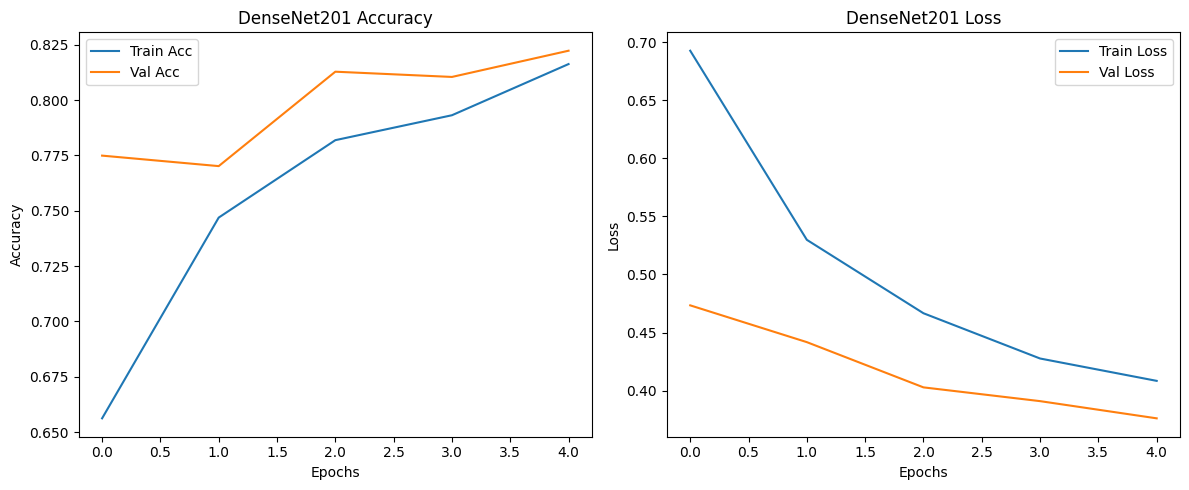

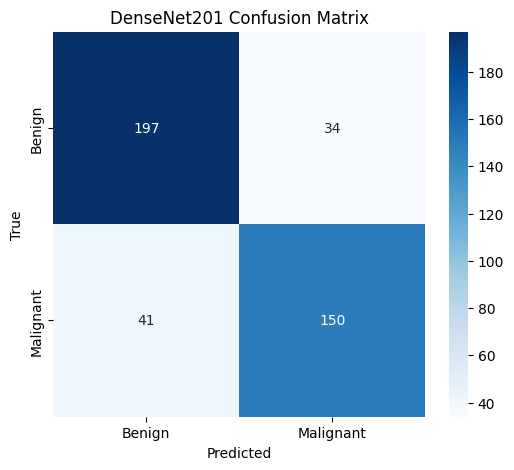


🔧 Training model: Xception
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.5619 - loss: 0.7267 - val_accuracy: 0.7512 - val_loss: 0.5136
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7643 - loss: 0.5071 - val_accuracy: 0.7559 - val_loss: 0.4758
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.7695 - loss: 0.4650 - val_accuracy: 0.7749 - val_loss: 0.4533
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.7977 - loss: 0.4355 - val_accuracy: 0.7749 - val_loss: 0.4365
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.8013 - loss: 0.4212 - val_accuracy: 0.7820 - val_loss: 0.4207
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step

✅ Xception Accuracy: 0.7820
📋 Classification Report for Xception:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       231
           1       0.76      0.75      0.76       191

    accuracy                           0.78       422
   macro avg      

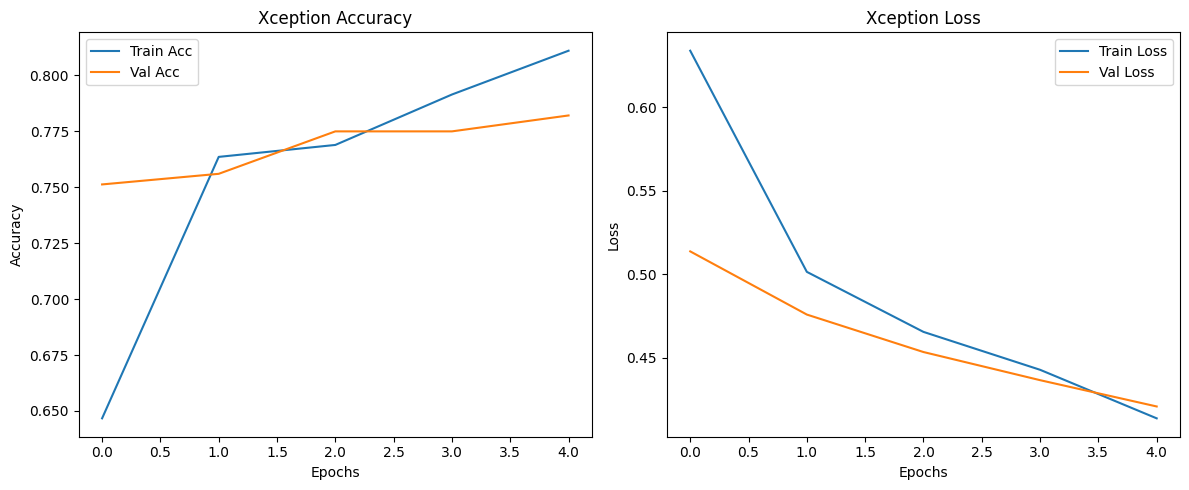

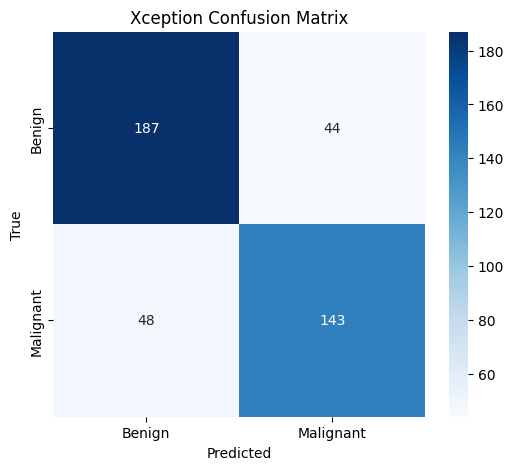

In [13]:
results = {}
for name, model_fn in architectures.items():
    print(f"\n🔧 Training model: {name}")
    model = model_fn()
    history = model.fit(train_ds, validation_data=val_ds, epochs=5)
    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([y for _, y in val_ds])
    y_true_classes = np.argmax(y_true, axis=1)
    acc = accuracy_score(y_true_classes, y_pred_classes)
    print(f"\n✅ {name} Accuracy: {acc:.4f}")
    print(f"📋 Classification Report for {name}:")
    print(classification_report(y_true_classes, y_pred_classes))
    plot_learning_curves(history, name)
    plot_confusion_matrix(y_true_classes, y_pred_classes, name)
    results[name] = {"model": model, "history": history}


C:\Users\LLR User\AppData\Local\Temp\ipykernel_14120\4195440098.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Model", y="Best Validation Accuracy", palette="viridis")
C:\Users\LLR User\AppData\Local\Temp\ipykernel_14120\4195440098.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LLR User\miniconda3\envs\tf-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


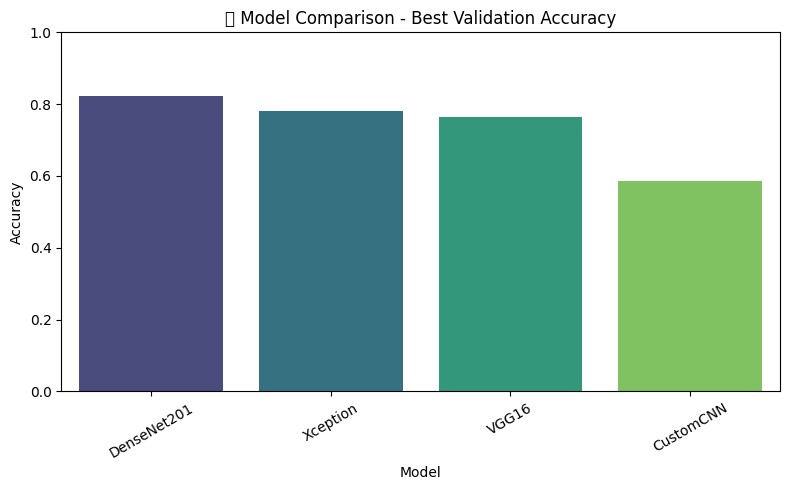

,Model,Best Validation Accuracy
2,DenseNet201,0.822275
3,Xception,0.781991
1,VGG16,0.765403
0,CustomCNN,0.585308


In [14]:
import matplotlib.pyplot as plt

# Create a comparison summary assuming accuracy is already computed during training
# This snippet should go at the end of your training loop to visualize results

# Extract accuracy and build a DataFrame for comparison
import pandas as pd

# Collect metrics from results dictionary (already populated)
model_names = []
accuracies = []
histories = []

for model_name, data in results.items():
    model_names.append(model_name)
    hist = data['history'].history
    histories.append(hist)
    if 'val_accuracy' in hist:
        acc = max(hist['val_accuracy'])
    else:
        acc = max(hist['accuracy'])
    accuracies.append(acc)

# Create a DataFrame for comparison
summary_df = pd.DataFrame({
    "Model": model_names,
    "Best Validation Accuracy": accuracies
}).sort_values(by="Best Validation Accuracy", ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Model", y="Best Validation Accuracy", palette="viridis")
plt.title("📊 Model Comparison - Best Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

summary_df
